# Setup Environment 

In [21]:
# pip install tensorflow

In [22]:
# pip install keras

In [23]:
# pip install opencv-python

In [24]:
# pip install imutils

In [25]:
# pip install matplotlib

In [26]:
# pip install seaborn

In [27]:
# pip install scikit-learn

# Import Library

In [1]:
# import shutil
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import regularizers
# from matplotlib.image import imread
# import matplotlib.image as plt_image
# from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Data Visualization

In [19]:
# import os
# import numpy as np

# PATH = '../data/data_preprocessing/v0.8/augmented'
# images, labels = [], []

# for dirname, _, filenames in os.walk(PATH):
#     for filename in filenames:
#         images.append(os.path.join(dirname, filename).split('/')[-1])  # /folder/blabla/xxx.jpg
#         labels.append(os.path.basename(dirname))  # Menggunakan nama folder sebagai label

# # Menggunakan np.unique untuk mendapatkan kelas unik
# # label2cat = np.unique(labels)
# # print("Kelas :", label2cat)

# # Membuat kamus untuk memetakan label ke kelas numerik
# # label_to_numeric = {label: idx for idx, label in enumerate(label2cat)}
# # print("Kamus Label ke Numerik:", label_to_numeric)
# # label_to_numeric

In [20]:
# import pandas as pd

# # Membuat DataFrame dari daftar gambar dan label
# datas = pd.DataFrame({'image_id': images, 'label': labels})

# # Menampilkan lima baris pertama dan bentuk DataFrame
# print(datas.head())
# print("Bentuk DataFrame:", datas.shape)

                                    image_id label
0  augmented\ba\ba116.pred3.b_aug_0_1033.png    ba
1  augmented\ba\ba116.pred3.b_aug_0_1069.png    ba
2  augmented\ba\ba116.pred3.b_aug_0_1077.png    ba
3  augmented\ba\ba116.pred3.b_aug_0_1095.png    ba
4  augmented\ba\ba116.pred3.b_aug_0_1097.png    ba
Bentuk DataFrame: (9860, 2)


In [23]:
# from sklearn.model_selection import train_test_split

# # Memisahkan data menjadi data latih (train) dan data uji (test)
# X_train, X_test, y_train, y_test = train_test_split(datas['image_id'].values, datas['label'].values,
#                                                     test_size=0.3, stratify=datas['label'].values,
#                                                     random_state=42)
# # Menampilkan jumlah data latih dan data uji
# print("Jumlah Data Training (X_train):", len(X_train))
# print("Jumlah Data Testing (X_test):", len(X_test))

Jumlah Data Training (X_train): 6902
Jumlah Data Testing (X_test): 2958


In [40]:
import os
from sklearn.model_selection import train_test_split

# Path ke direktori utama yang berisi sub-direktori untuk masing-masing kelas
main_data_dir = '../data/data_preprocessing/v0.8/augmented'

# Mendefinisikan list untuk data dan label
X, y = [], []

# Loop melalui masing-masing kelas (diasumsikan ada 20 kelas)
for class_name in os.listdir(main_data_dir):
    class_path = os.path.join(main_data_dir, class_name)
    
    # Mendapatkan list file untuk kelas tertentu
    files = os.listdir(class_path)
    
    # Menambahkan path file dan label ke dalam list X dan y
    X.extend([os.path.join(class_path, file) for file in files])
    y.extend([class_name] * len(files))

# Melakukan pembagian data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

# Verifikasi output
print("Jumlah Data Training (X_train):", len(X_train))
print("Jumlah data Testing (X_test):", len(X_test))

Jumlah Data Training (X_train): 6902
Jumlah data Testing (X_test): 2958


In [41]:
# Tentukan konstanta
epochs = 5
batch_size = 64
num_classes = 20
image_size = (64, 64)
input_shape = (64, 64,1)

# Class = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 
        #  'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

# train_dir = "../data/data_preprocessing/v0.7/data_split_a1/train/"
# test_dir = "../data/data_preprocessing/v0.7/data_split_a1/test/"

In [42]:
import os

# Menghitung jumlah gambar per kelas
file_list = os.listdir(main_data_dir)

jumlah_gambar_per_kelas = []

for kelas in file_list:
    kelas_path = os.path.join(main_data_dir, kelas)
    jumlah_gambar = len(os.listdir(kelas_path))
    jumlah_gambar_per_kelas.append(jumlah_gambar)

# Mengecek apakah jumlah data per kelas sudah seimbang
balanced = all(jumlah == jumlah_gambar_per_kelas[0] for jumlah in jumlah_gambar_per_kelas)

# Menampilkan pesan sesuai dengan hasil pemeriksaan
if balanced:
    print("Balanced Data !")
else:
    print("Imbalanced Data !!!\n")
    # Jika imbalanced, tampilkan jumlah data per kelas
    for kelas, jumlah in zip(file_list, jumlah_gambar_per_kelas):
        print(f'Aksara {kelas} jumlah: {jumlah}')

Balanced Data !


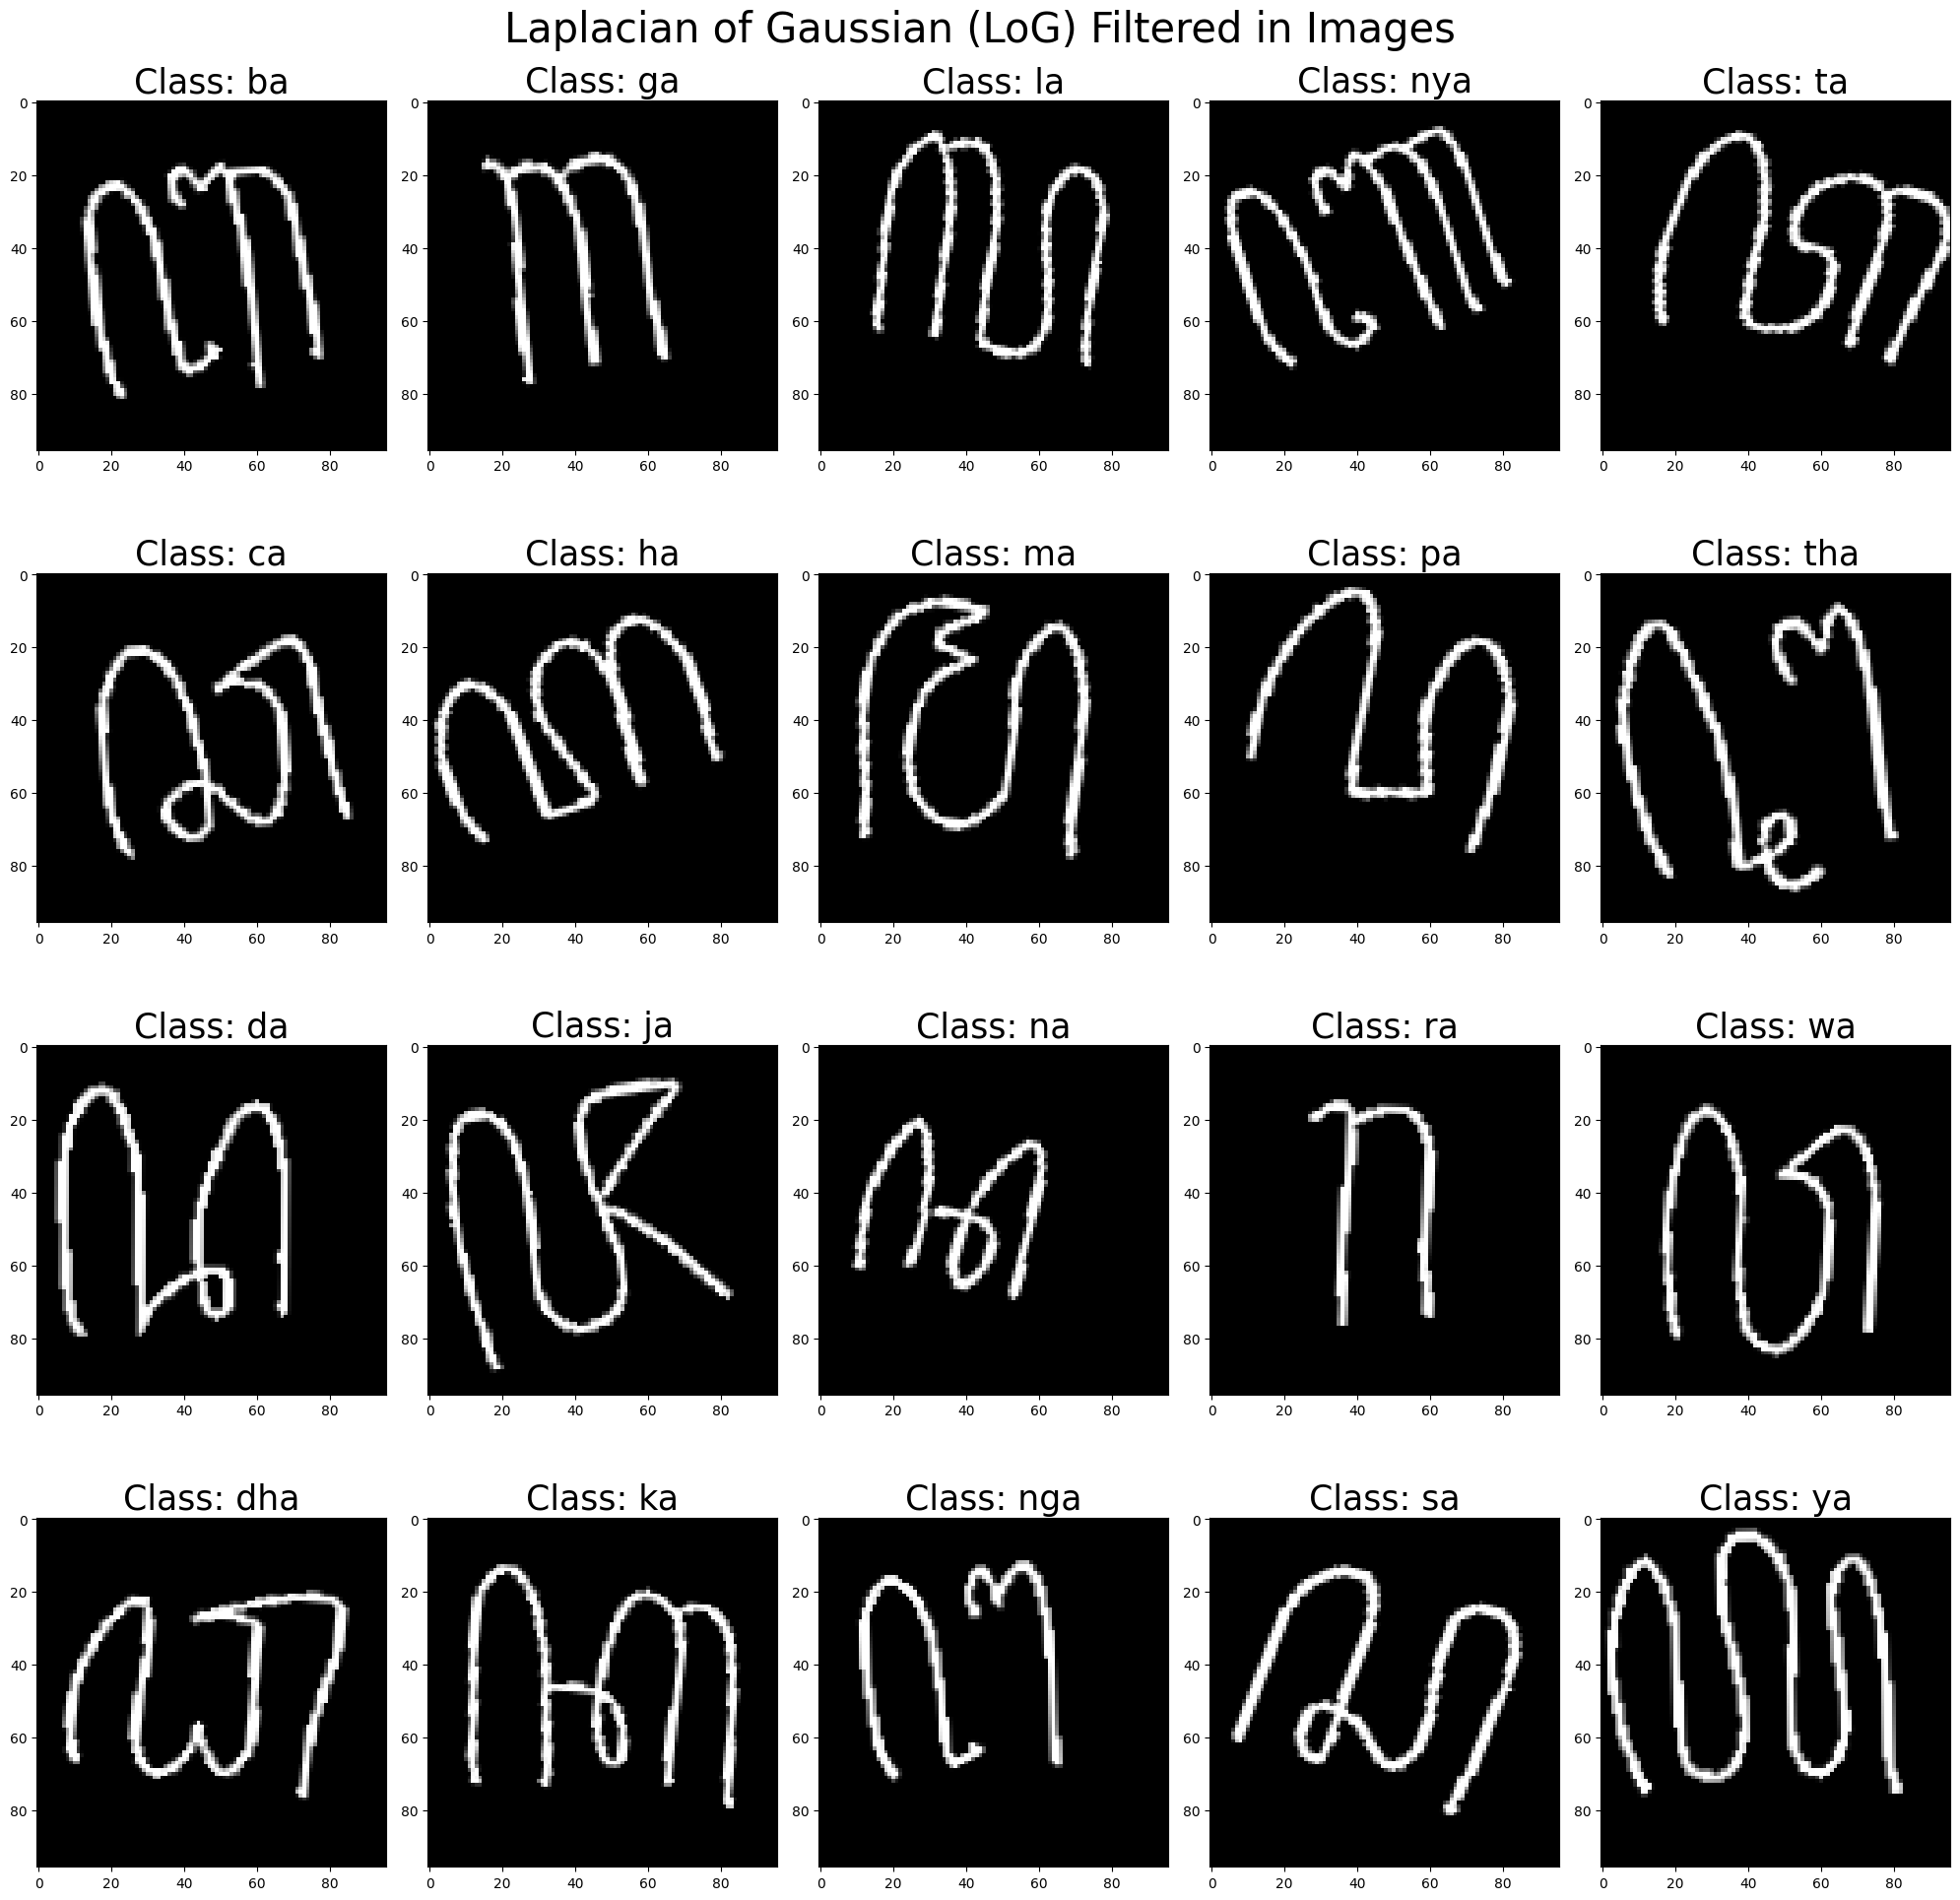

In [43]:
import cv2
import matplotlib.pyplot as plt
import random

class ImageProcessor:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path

    def display_random_image(self):
        # Inisialisasi plot
        fig, axes = plt.subplots(4, 5, figsize=(20, 20))

        # Iterasi melalui setiap subfolder
        for i, folder_name in enumerate(os.listdir(self.dataset_path)):
            folder_path = os.path.join(self.dataset_path, folder_name)

            # Pastikan yang diakses adalah subfolder
            if os.path.isdir(folder_path):

                # Mengambil satu gambar acak dari subfolder
                image_names = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                random_image_name = random.choice(image_names)
                random_image_path = os.path.join(folder_path, random_image_name)

                # Membaca dan menampilkan gambar menggunakan Matplotlib
                random_image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
                axes[i % 4, i // 4].imshow(random_image, cmap='gray')
                axes[i % 4, i // 4].set_title(f"Class: {folder_name}", fontsize=25)
                axes[i % 4, i // 4].axis('on')
                
        # Menambahkan Title Class Visualization 
        plt.suptitle("Laplacian of Gaussian (LoG) Filtered in Images", fontsize=30)

        # Menampilkan plot
        plt.tight_layout()
        plt.show()

dataset_path = main_data_dir

# Inisialisasi objek ImageProcessor dan panggil metode display_random_image
processor = ImageProcessor(dataset_path)
processor.display_random_image()

In [44]:
def count_files(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        count = 0
        for name in files:
            if name.endswith(".png"):
              count = count + 1
        if count > 0:
          arr.append(count)
    return arr

def get_all_char_names(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        # print(dirs)
        arr.append(dirs)
        break
    return arr


20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


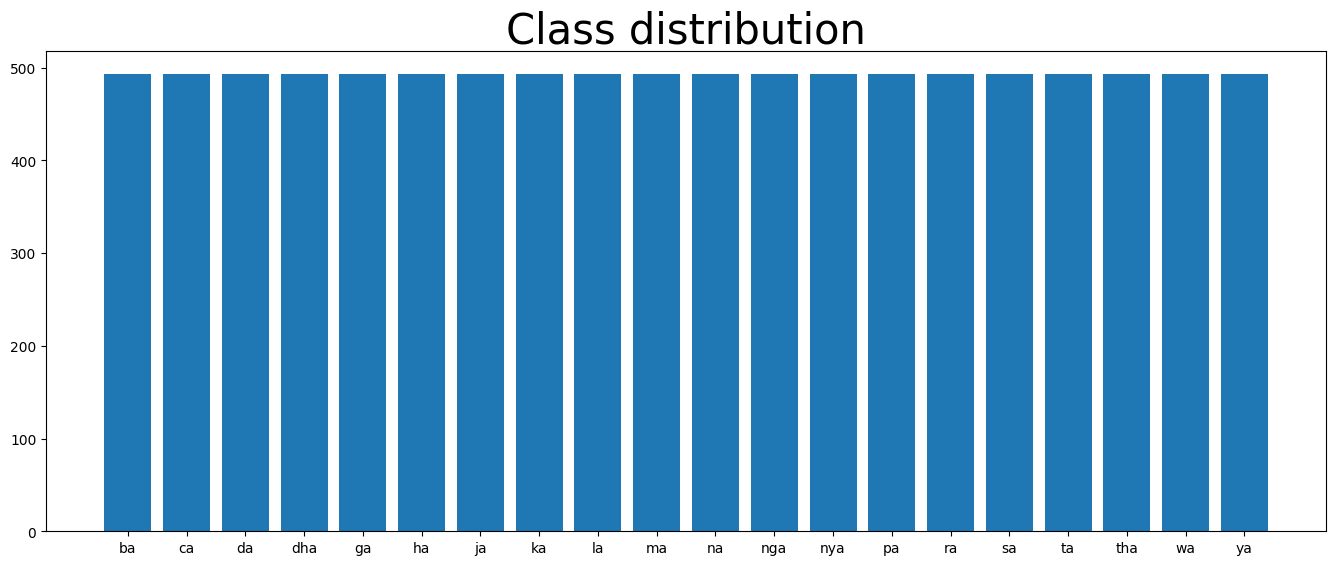

In [45]:
# Training Class
image_count = count_files(main_data_dir)
print(len(image_count))
chars = get_all_char_names(main_data_dir)
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(chars[0], image_count)
plt.title("Class distribution", fontsize=30)
plt.show()

# Testing Class
# image_count = count_files(test_dir)
# print(len(image_count))
# chars = get_all_char_names(test_dir)
# print(chars)

# fig = plt.figure()
# ax = fig.add_axes([0,0,2,1])
# ax.bar(chars[0], image_count)
# plt.title("Testing class distribution")
# plt.show()

# Build the Model

### Image Data Generator

In [48]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
test_df = pd.DataFrame({'filename': X_test, 'class': y_test})

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,  
    batch_size=batch_size,  
    class_mode='categorical', 
    color_mode='grayscale'  
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,  
    batch_size=batch_size,  
    class_mode='categorical', 
    color_mode='grayscale'  
)

Found 6902 validated image filenames belonging to 20 classes.
Found 2958 validated image filenames belonging to 20 classes.


In [36]:
# from sklearn.utils.class_weight import compute_sample_weight

# # Mencari class weights untuk mengatasi ketidakseimbangan kelas
# class_weights = compute_sample_weight('balanced', train_generator.classes)
# class_weight = dict(enumerate(class_weights))

### Model - CNN + VGG

In [37]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam

# def build_vgg16(input_shape=(128, 128, 1), num_classes=num_classes):
#     inputs = Input(shape=input_shape)

#     # Blok 1
#     conv1_1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
#     batchnorm1_1 = BatchNormalization()(conv1_1)
#     conv1_2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm1_1)
#     batchnorm1_2 = BatchNormalization()(conv1_2)
#     maxpool1 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm1_2)

#     # Blok 2
#     conv2_1 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(maxpool1)
#     batchnorm2_1 = BatchNormalization()(conv2_1)
#     conv2_2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm2_1)
#     batchnorm2_2 = BatchNormalization()(conv2_2)
#     maxpool2 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm2_2)

#     # Blok 3
#     conv3_1 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(maxpool2)
#     batchnorm3_1 = BatchNormalization()(conv3_1)
#     conv3_2 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm3_1)
#     batchnorm3_2 = BatchNormalization()(conv3_2)
#     conv3_3 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm3_2)
#     batchnorm3_3 = BatchNormalization()(conv3_3)
#     maxpool3 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm3_3)

#     # Blok 4
#     conv4_1 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(maxpool3)
#     batchnorm4_1 = BatchNormalization()(conv4_1)
#     conv4_2 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm4_1)
#     batchnorm4_2 = BatchNormalization()(conv4_2)
#     conv4_3 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm4_2)
#     batchnorm4_3 = BatchNormalization()(conv4_3)
#     maxpool4 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm4_3)

#     # Blok 5
#     conv5_1 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(maxpool4)
#     batchnorm5_1 = BatchNormalization()(conv5_1)
#     conv5_2 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm5_1)
#     batchnorm5_2 = BatchNormalization()(conv5_2)
#     conv5_3 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm5_2)
#     batchnorm5_3 = BatchNormalization()(conv5_3)
#     maxpool5 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm5_3)

#     # Fully connected layers
#     flatten = Flatten(name='flatten')(maxpool5)

#     dense1 = Dense(256, activation='relu')(flatten)
#     batchnorm_dense1 = BatchNormalization()(dense1)
#     dropout1 = Dropout(0.75)(batchnorm_dense1)

#     dense2 = Dense(128, activation='relu')(dropout1)
#     batchnorm_dense2 = BatchNormalization()(dense2)
#     dropout2 = Dropout(0.75)(batchnorm_dense2)

#     outputs = Dense(num_classes, activation='softmax')(dropout2)

#     model = Model(inputs=inputs, outputs=outputs)

#     return model

# # Create the VGG16 model
# model = build_vgg16()

# # Adam optimizer with learning rate scheduling, Weight Decay, and Gradient Clipping
# opt = Adam(learning_rate=0.0001, 
#            weight_decay=1e-4, 
#            clipvalue=0.5
#            )
    
# # Compile the model
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

### Model_v1

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_vgg16(input_shape=input_shape, num_classes=num_classes):
    model = Sequential()

    # Blok 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))

    # Blok 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))

    # Blok 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))

    # Blok 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))
    
    # Blok 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.75))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))
    
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the VGG16 model
model = build_vgg16()

# # Adam optimizer with learning rate scheduling, Weight Decay, and Gradient Clipping
opt = Adam(learning_rate=0.0001, weight_decay=1e-4, clipvalue=0.5)
    
# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 8, 512)      │         2,04

 Total params: 15,327,956 (58.47 MB)

 Trainable params: 15,318,484 (58.44 MB)

 Non-trainable params: 9,472 (37.00 KB)

In [53]:
# Melakukan pelatihan model
history_v1 = model.fit(train_generator,
                         batch_size=batch_size,
                         epochs=epochs, 
                         validation_data=test_generator)

Epoch 1/5


c:\Users\wawn1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 2929s 26s/step - accuracy: 0.2996 - loss: 3.4648 - val_accuracy: 0.0521 - val_loss: 4.1257
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 2498s 23s/step - accuracy: 0.9575 - loss: 0.1569 - val_accuracy: 0.0521 - val_loss: 8.0838
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 2465s 23s/step - accuracy: 0.9932 - loss: 0.0482 - val_accuracy: 0.0521 - val_loss: 10.0629
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 2452s 23s/step - accuracy: 0.9965 - loss: 0.0278 - val_accuracy: 0.0521 - val_loss: 10.6607
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 2351s 22s/step - accuracy: 0.9988 - loss: 0.0180 - val_accuracy: 0.0521 - val_loss: 7.6504


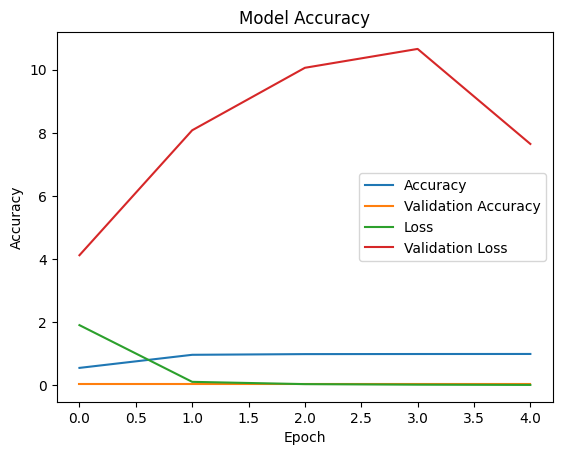

In [54]:
import matplotlib.pyplot as plt

plt.plot(history_v1.history["accuracy"])
plt.plot(history_v1.history['val_accuracy'])
plt.plot(history_v1.history['loss'])
plt.plot(history_v1.history['val_loss'])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

### Model 2

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def build_vgg16(input_shape, num_classes):
    model = Sequential()

    # Blok 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))

    # Blok 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))

    # Blok 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))

    # Blok 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))
    
    # Blok 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(0.75))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.75))
    
    model.add(Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))
    
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Define input_shape and num_classes
input_shape = input_shape  # Example shape, modify according to your data
num_classes = num_classes  # Example number of classes, modify according to your data

# Create the VGG16 model
model = build_vgg16(input_shape, num_classes)

# Adam optimizer with learning rate scheduling, Weight Decay, and Gradient Clipping
opt = Adam(learning_rate=0.0001, weight_decay=1e-4, clipvalue=0.5)
    
# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 8, 8, 512)      │         2,04

 Total params: 15,327,956 (58.47 MB)

 Trainable params: 15,318,484 (58.44 MB)

 Non-trainable params: 9,472 (37.00 KB)

In [57]:
# Melakukan pelatihan model
history_v2 = model.fit(train_generator,
                         batch_size=batch_size,
                         epochs=epochs, 
                         validation_data=test_generator)

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 1491s 14s/step - accuracy: 0.3119 - loss: 3.7411 - val_accuracy: 0.0521 - val_loss: 4.1664
Epoch 2/5
 32/108 ━━━━━━━━━━━━━━━━━━━━ 20:31 16s/step - accuracy: 0.9536 - loss: 0.6322

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_v2.history["accuracy"])
plt.plot(history_v2.history['val_accuracy'])
plt.plot(history_v2.history['loss'])
plt.plot(history_v2.history['val_loss'])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

### Model Graph

In [ ]:
# acc = history.history['accuracy']
# loss = history.history['loss']
# epochs_range = range(len(acc))

# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.title('Training Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(loc='upper right')

# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# def plot_training_history(history):
#     # Mengambil data loss dan akurasi dari history
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']

#     # Menampilkan grafik loss
#     plt.figure(figsize=(10, 5))
#     plt.plot(loss, label='Training Loss')
#     plt.plot(val_loss, label='Validation Loss')
#     plt.title('Training and Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

#     # Menampilkan grafik akurasi
#     plt.figure(figsize=(10, 5))
#     plt.plot(accuracy, label='Training Accuracy')
#     plt.plot(val_accuracy, label='Validation Accuracy')
#     plt.title('Training and Validation Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()

# # Panggil fungsi plot_training_history dengan history dari pelatihan model
# plot_training_history(history)

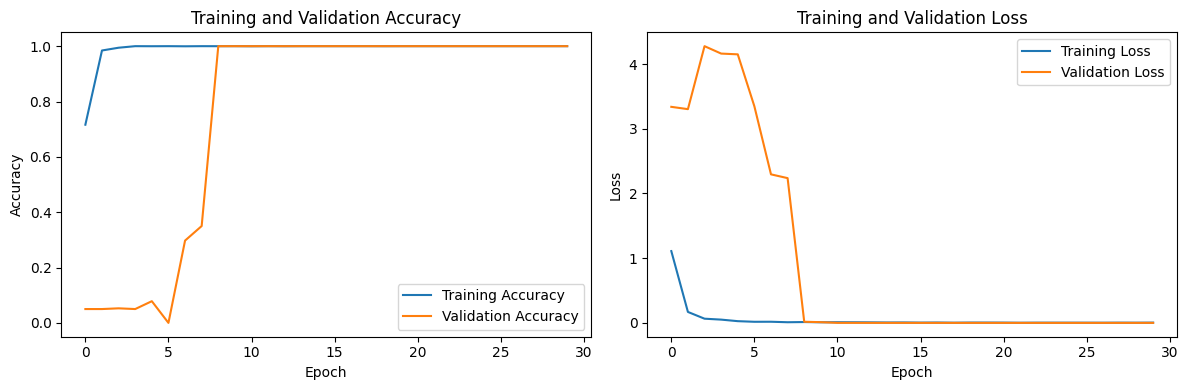

In [ ]:
# Menampilkan grafik training dan validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Try Predict

In [ ]:
from tensorflow.keras.models import load_model

# Saved Model
saved_model_path = checkpoint_filepath
model.save(saved_model_path)

# Memuat model dari file yang disimpan
loaded_model = load_model(saved_model_path)

# Evaluasi model menggunakan data uji
loss, accuracy = loaded_model.evaluate(test_generator)

# Print hasil evaluasi
print("Loss:", loss)
print("Accuracy:", accuracy)


61/61 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 1.0000 - loss: 2.0089e-04
Loss: 0.00019614261691458523
Accuracy: 1.0


In [ ]:
# Import the necessary modules
from sklearn import metrics
import math

test_steps_per_epoch = math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Hitung dan tampilkan classification report
report = metrics.classification_report(true_classes,
                                       predicted_classes,
                                       target_names = class_labels)
print(report)

61/61 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step
              precision    recall  f1-score   support

          ba       0.03      0.03      0.03       193
          ca       0.04      0.04      0.04       193
          da       0.03      0.03      0.03       193
         dha       0.04      0.04      0.04       193
          ga       0.06      0.06      0.06       193
          ha       0.06      0.06      0.06       193
          ja       0.06      0.06      0.06       193
          ka       0.06      0.06      0.06       193
          la       0.05      0.05      0.05       193
          ma       0.04      0.04      0.04       193
          na       0.05      0.05      0.05       193
         nga       0.04      0.04      0.04       193
         nya       0.06      0.06      0.06       193
          pa       0.04      0.04      0.04       193
          ra       0.02      0.02      0.02       193
          sa       0.08      0.08      0.08       193
          ta       0.06      0.06      0.

In [ ]:
import pandas as pd
import seaborn as sn

# Buat DataFrame untuk confusion matrix
df_cm = pd.DataFrame(confusion_matrix,
                     index=[i for i in ("ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma",
                                        "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya")],

                     columns=[i for i in ("ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma",
                                          "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya")])
# Tampilkan heatmap
plt.figure(figsize=(15, 15))
sn.heatmap(df_cm, annot=True)

NameError: name 'confusion_matrix' is not defined

In [ ]:
# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import roc_curve, auc, roc_auc_score
# import numpy as np


# # Make predictions
# pred = model.predict(test_generator)

# # Extract true labels from generator
# true_labels = true_classes  

# # One-hot encode true labels
# true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# # Compute ROC curve and ROC AUC for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], pred[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC AUC score
# fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_one_hot.ravel(), pred.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink',
#           'cyan', 'magenta', 'yellow', 'orange', 'lime', 'blue', 'green', 'brown', 'indigo', 'violet', 'olive', 'teal']

# # Plot the ROC curves for each class and the micro-average ROC curve
# plt.figure(figsize=(8, 6))
# lw = 2

# plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
#                                                    ''.format(roc_auc["micro"]))

# for i, color in zip(range(num_classes), colors):  
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    
# plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate', fontsize=14)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
# plt.legend(loc="lower right", fontsize=12)
# plt.show()

# Try Test

In [ ]:
# from keras.preprocessing import image
# import numpy as np

# # Muat model kembali dari variabel
# loaded_model = load_model(saved_model_path)

# # Load the grayscale image
# # test_image_path1 = '../data/data_original/javaneseScript_byPhiard/prediction/ba17.png'
# test_image_path1 = '../data/data_preprocessing/v0.3/data_split/test/ba/grayscale_ba116.pred3.b_aug_0_80.png'
# img = image.load_img(test_image_path1, color_mode='grayscale', target_size=(128, 128))

# # Convert the image to array
# img_array = image.img_to_array(img)

# # Expand the dimensions to match the input shape of the model
# img_array = np.expand_dims(img_array, axis=0)

# # Perform the prediction
# predictions = model.predict(img_array)

# # Get the predicted class index
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Muat model kembali dari variabel
# loaded_model = load_model(saved_model_path)

# # Menguji Model
# test_image_path1 = '../data/data_original/javaneseScript_byPhiard/prediction/ba17.png'
# img = image.load_img(test_image_path1, target_size=(64, 64))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path1)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# # predictions = loaded_model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path2 = '../data/databyPhiard_original/prediction/ba49.mine2.png'
# img = image.load_img(test_image_path2, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path2)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path3 = '../data/databyPhiard_original/prediction/ca2.png'
# img = image.load_img(test_image_path3, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path3)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path4 = '../data/databyPhiard_original/prediction/da5.png'
# img = image.load_img(test_image_path4, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path4)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path5 = '../data/databyPhiard_original/prediction/dha11.png'
# img = image.load_img(test_image_path5, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path5)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path6 = '../data/databyPhiard_original/prediction/ga16.png'
# img = image.load_img(test_image_path6, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path6)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path7 = '../data/databyPhiard_original/prediction/ha0.png'
# img = image.load_img(test_image_path7, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path7)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path8 = '../data/databyPhiard_original/prediction/ja12.png'
# img = image.load_img(test_image_path8, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path8)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path9 = '../data/databyPhiard_original/prediction/ka4.png'
# img = image.load_img(test_image_path9, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path9)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path10 = '../data/databyPhiard_original/prediction/la9.png'
# img = image.load_img(test_image_path10, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path10)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path11 = '../data/databyPhiard_original/prediction/ma.0.jpg'
# img = image.load_img(test_image_path11, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path11)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path12 = '../data/databyPhiard_original/prediction/ma.1.jpg'
# img = image.load_img(test_image_path12, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path12)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path13 = '../data/databyPhiard_original/prediction/ma15.png'
# img = image.load_img(test_image_path13, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path13)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path14 = '../data/databyPhiard_original/prediction/na1.png'
# img = image.load_img(test_image_path14, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path14)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path15 = '../data/databyPhiard_original/prediction/nga19.png'
# img = image.load_img(test_image_path15, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path15)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path16 = '../data/databyPhiard_original/prediction/nga220.pred.png'
# img = image.load_img(test_image_path16, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path16)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path17 = '../data/databyPhiard_original/prediction/nya14.png'
# img = image.load_img(test_image_path17, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path17)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path18 = '../data/databyPhiard_original/prediction/pa10.png'
# img = image.load_img(test_image_path18, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path18)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path19 = '../data/databyPhiard_original/prediction/ra164.pred.png'
# img = image.load_img(test_image_path19, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path19)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path20 = '../data/databyPhiard_original/prediction/ra3.png'
# img = image.load_img(test_image_path20, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path20)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path21 = '../data/databyPhiard_original/prediction/sa7.png'
# img = image.load_img(test_image_path21, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path21)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path22 = '../data/databyPhiard_original/prediction/ta6.png'
# img = image.load_img(test_image_path22, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path22)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path23 = '../data/databyPhiard_original/prediction/tha18.png'
# img = image.load_img(test_image_path23, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path23)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path24 = '../data/databyPhiard_original/prediction/wa8.png'
# img = image.load_img(test_image_path24, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path24)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path25 = '../data/databyPhiard_original/prediction/ya13.png'
# img = image.load_img(test_image_path25, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path25)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/nya_01.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/sa_01.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/ha201.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)